In [1]:
from pathlib import Path

# Check package versions
import numpy as np
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from regions import CircleSkyRegion

import matplotlib.pyplot as plt

In [2]:
from IPython.display import display
from gammapy.data import DataStore
from gammapy.datasets import (
    Datasets,
    FluxPointsDataset,
    SpectrumDataset,
    SpectrumDatasetOnOff,
)
from gammapy.estimators import FluxPointsEstimator
from gammapy.makers import (
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
)
from gammapy.maps import MapAxis, RegionGeom, WcsGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    ExpCutoffPowerLawSpectralModel,
    SkyModel,
    create_crab_spectral_model,
)
from gammapy.modeling.models import Models, PowerLawSpectralModel, SkyModel

/homes/wang/swong/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import data

Datastore is whichever directory on your computer has your DL3 fits files as well as `hdu-index.fits.gz` and `obs-index.fits.gz`

For now, VERITAS only outputs point-like IRFs, so don't change this

In [3]:
data_store = DataStore.from_dir("/raid/romulus/swong/LIV/mrk4212008") 
observations = data_store.get_observations(required_irf="point-like")
print(observations)

Observations
Number of observations: 2
Observation

	obs id            : 40640 
 	tstart            : 54588.29
	tstop             : 54588.30
	duration          : 1203.00 s
	pointing (icrs)   : 166.1 deg, 38.7 deg

	deadtime fraction : 7.4%
Observation

	obs id            : 40682 
 	tstart            : 54589.31
	tstop             : 54589.32
	duration          : 1203.00 s
	pointing (icrs)   : 166.1 deg, 37.7 deg

	deadtime fraction : 7.7%



`obs_ids` corresponds to the run numbers you're using (should look like the run names on loggen)

In [4]:
target_position = SkyCoord(166.0791667 * u.deg, 38.1947222* u.deg, frame="icrs")
selection = dict(
    type="sky_circle",
    frame="icrs",
    lon=target_position.ra,
    lat=target_position.dec,
    radius=2 * u.deg,
)
obs_ids = data_store.obs_table.select_observations(selection)["OBS_ID"]
observations = data_store.get_observations(obs_ids,skip_missing=False,required_irf='point-like')
print(f"Number of selected observations : {len(observations)}")

Number of selected observations : 2


# Source Details

Make sure too change `target_position` so that it is specific to your source - you can usually find this info on TeVCat: http://tevcat.uchicago.edu/

`on_region_radius` shouldn't change between VERITAS sources but will change from values used for MAGIC and H.E.S.S., so make sure this is 0.08944272 deg

`energy_axis` corresponds to the energies you want to use (in TeV), which will differ slightly from paper to paper. The region that VERITAS can (accurately) reconstruct is by default from 110 GeV to 8 TeV

You can use either a reflected region (wobble) background or ring background. There shouldn't be a huge difference for point source analysis, but generally good to stick to the method used in the paper/wiki page for validating (if it is mentioned).

You should change nbin (in `energy_axis`) to match the number of bins in the paper in order to get results that are easily comparable

In [5]:
on_region_radius = Angle("0.08944272 deg") #this should always be the same for VERITAS analysis
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

In [87]:
energy_axis = MapAxis.from_energy_bounds(
    0.11, 8, nbin=10, per_decade=True, unit="TeV", name="energy" #change this based on analysis (LG saturation @ 8 TeV)
)
energy_axis_true = MapAxis.from_energy_bounds(
    0.11, 20, nbin=20, per_decade=True, unit="TeV", name="energy_true" #ditto
)

geom = RegionGeom.create(region=on_region, axes=[energy_axis])
dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

dataset_maker = SpectrumDatasetMaker(
    containment_correction=False, selection=["counts", "exposure", "edisp"]
)
bkg_maker = ReflectedRegionsBackgroundMaker() #can change to RB for archival validation, if appropriate
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

# Make background region and mask

This just selects the on and off regions for each run (nothing to change here)

Below you'll see some info for each run that will be used to compute some higher level data products later on.

In [88]:
datasets = Datasets()
for obs_id, observation in zip(obs_ids, observations):
    dataset = dataset_maker.run(dataset_empty.copy(name=str(obs_id)), observation)
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    datasets.append(dataset_on_off)

print(datasets)

/homes/wang/swong/lib/python3.9/site-packages/gammapy/maps/geom.py:48: RuntimeWarning: invalid value encountered in cast
  p_idx = np.rint(p).astype(int)
/homes/wang/swong/lib/python3.9/site-packages/gammapy/maps/geom.py:48: RuntimeWarning: invalid value encountered in cast
  p_idx = np.rint(p).astype(int)
/homes/wang/swong/lib/python3.9/site-packages/gammapy/maps/geom.py:48: RuntimeWarning: invalid value encountered in cast
  p_idx = np.rint(p).astype(int)


Datasets
--------

Dataset 0: 

  Type       : SpectrumDatasetOnOff
  Name       : 40640
  Instrument : VERITAS
  Models     : 

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : 40682
  Instrument : VERITAS
  Models     : 




/homes/wang/swong/lib/python3.9/site-packages/gammapy/maps/geom.py:48: RuntimeWarning: invalid value encountered in cast
  p_idx = np.rint(p).astype(int)


In [89]:
info_table = datasets.info_table(cumulative=True)

display(info_table)

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,410,401.8823547363281,42.04014431977828,8.117647171020508,30.444444551558043,30.444444551558043,nan,57710.0390625,191583312.0,1114.465839860747,1203.0,0.36788924822606467,0.007283890524661402,0.3606053594128497,19,14,wstat,1835.7276472919505,138,14.0,238.0,0.05882352963089943
stacked,743,727.682373046875,55.996052547526936,15.317646980285645,58.651797320229186,58.651797320229186,nan,60260.1796875,421780448.0,2224.982879615579,2406.0,0.3339351537520018,0.006884388693782735,0.32705077405925936,19,14,wstat,3215.4596528668626,246,14.0,224.83871459960938,0.06226685643196106


# Extract Source Characteristics for LIVelihood

Ignore this for now, unless you're doing a LIV analysis, in which case, run the next few cells (i.e., otherwise just delete until the next heading)

In [90]:
Nexcess = sum(datasets.info_table()["excess"])
Nbackground = sum(datasets.info_table()["background"])

print(f'Excess Photon Counts: {Nexcess}')
print(f'Hadron Counts: {Nbackground}')

Excess Photon Counts: 727.6823547363281
Hadron Counts: 15.317647171020509


In [91]:
from gammapy.data import EventList
events1 = EventList.read("/raid/romulus/swong/LIV/mrk4212008/40682.fits")
events2 = EventList.read("/raid/romulus/swong/LIV/mrk4212008/40640.fits")

print(events1)
print(events2)

stacked = events1.stack(events2)

EventList
---------

  Instrument       : VERITAS
  Telescope        : VERITAS
  Obs. ID          : 40682

  Number of events : 2747
  Event rate       : 2.284 1 / s

  Time start       : 54589.30958760667
  Time stop        : 54589.32350623695

  Min. energy      : 3.17e-01 TeV
  Max. energy      : 1.34e+01 TeV
  Median energy    : 7.11e-01 TeV

  Max. offset      : 2.0 deg

EventList
---------

  Instrument       : VERITAS
  Telescope        : VERITAS
  Obs. ID          : 40640

  Number of events : 2742
  Event rate       : 2.280 1 / s

  Time start       : 54588.29027134408
  Time stop        : 54588.30418881563

  Min. energy      : 2.38e-01 TeV
  Max. energy      : 9.36e+00 TeV
  Median energy    : 4.64e-01 TeV

  Max. offset      : 2.0 deg



In [92]:
Nevents = 2747 + 2742
Nevents

5489

# Cumulative significance maps

This shows you the significance of gamma-rays over background (right) and excess gamma-rays over background (left) as a function of time. If you have growing significance, this is good! That means there's probably something there :)

Text(0, 0.5, 'Sqrt(TS)')

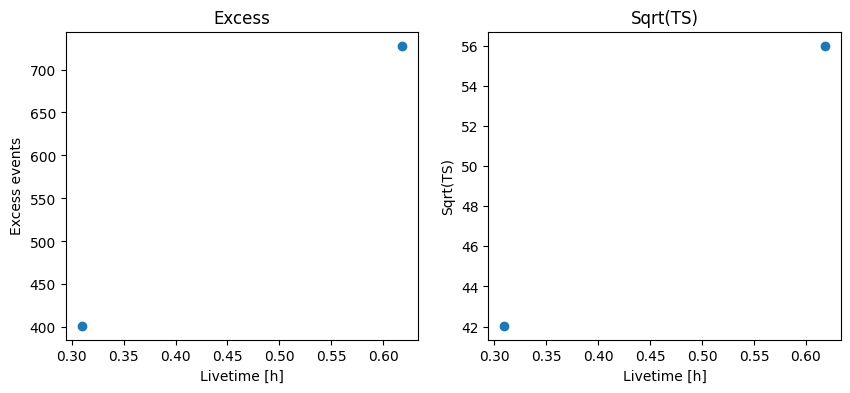

In [93]:
fig, (ax_excess, ax_sqrt_ts) = plt.subplots(figsize=(10, 4), ncols=2, nrows=1)
ax_excess.plot(
    info_table["livetime"].to("h"),
    info_table["excess"],
    marker="o",
    ls="none",
)

ax_excess.set_title("Excess")
ax_excess.set_xlabel("Livetime [h]")
ax_excess.set_ylabel("Excess events")

ax_sqrt_ts.plot(
    info_table["livetime"].to("h"),
    info_table["sqrt_ts"],
    marker="o",
    ls="none",
)

ax_sqrt_ts.set_title("Sqrt(TS)")
ax_sqrt_ts.set_xlabel("Livetime [h]")
ax_sqrt_ts.set_ylabel("Sqrt(TS)")

# Spectral model

This is going to fit a spectrum and is the output we essentially want from this notebook

You're going to choose a spectral model that corresponds to the model in the paper. The gammapy names for all of these are found here: https://docs.gammapy.org/1.0/api/gammapy.modeling.models.SpectralModel.html#gammapy.modeling.models.SpectralModel (look for anything w/ suffic SpectralModel in the accordian menu on the left side of the page). The most common spectral models are power law, log parabola, and exponential cutoff power law. The spectral index can be found on TeVCat or in the paper, and all other parameters should also be in the paper.

These cells will do a best fit of the data to the model you've provided and output the fit parameters in the table below.

In [94]:
spectral_model = ExpCutoffPowerLawSpectralModel( #this is all info from paper/TeVCat/iteration/etc.
    amplitude=1e-12 * u.Unit("cm-2 s-1 TeV-1"),
    index=2,
    lambda_=0.25 * u.Unit("TeV-1"),
    reference=1 * u.TeV,
)
print(spectral_model)
model = SkyModel(spectral_model=spectral_model, name="mrk421") #change name w/ source

datasets.models = [model]

fit_joint = Fit()
result_joint = fit_joint.run(datasets=datasets)

# we make a copy here to compare it later
model_best_joint = model.copy()

ExpCutoffPowerLawSpectralModel

  type      name     value         unit        error   min max frozen is_norm link
-------- --------- ---------- -------------- --------- --- --- ------ ------- ----
spectral     index 2.0000e+00                0.000e+00 nan nan  False   False     
spectral amplitude 1.0000e-12 cm-2 s-1 TeV-1 0.000e+00 nan nan  False    True     
spectral reference 1.0000e+00            TeV 0.000e+00 nan nan   True   False     
spectral   lambda_ 2.5000e-01          TeV-1 0.000e+00 nan nan  False   False     
spectral     alpha 1.0000e+00                0.000e+00 nan nan   True   False     


In [95]:
display(result_joint.models.to_parameters_table())

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str6,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
mrk421,spectral,index,1.9063e+00,,1.397e-01,nan,nan,False,False,
mrk421,spectral,amplitude,3.3528e-10,cm-2 s-1 TeV-1,3.936e-11,nan,nan,False,True,
mrk421,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
mrk421,spectral,lambda_,3.0203e-01,TeV-1,8.456e-02,nan,nan,False,False,
mrk421,spectral,alpha,1.0000e+00,,0.000e+00,nan,nan,True,False,


# Plot fit results with data

The below plot just shows the best fit model to the data

Text(0.5, 1.0, 'Mrk 421')

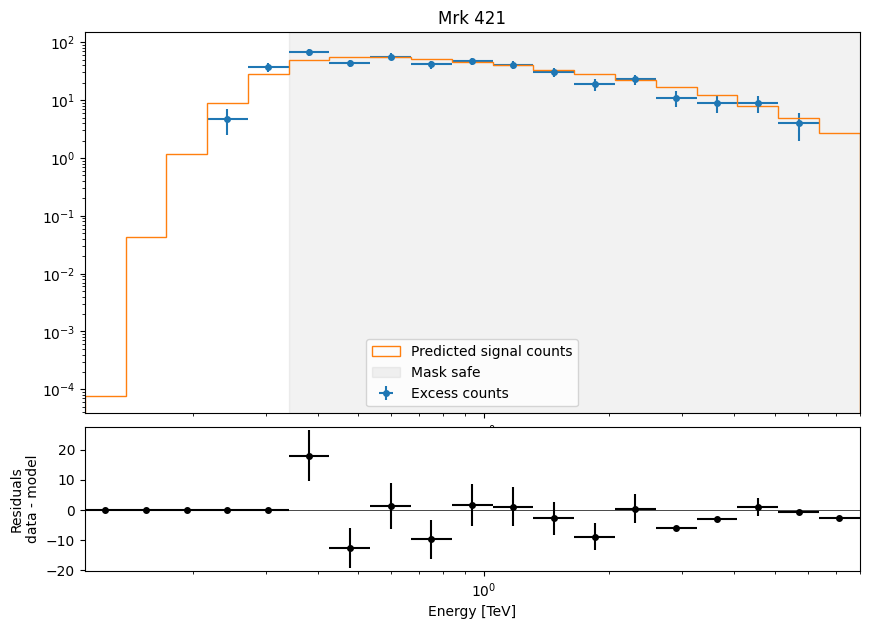

In [96]:
plt.figure(figsize=(10,7))
ax_spectrum, ax_residuals = datasets[0].plot_fit()
ax_spectrum.set_yscale('log')
datasets[0].plot_masks(ax=ax_spectrum)
ax_spectrum.set_title('Mrk 421')

The number of bins in `energy_edges` is the number of spectral points you want + 1

In [109]:
e_min, e_max = 0.110, 8
energy_edges = np.geomspace(e_min, e_max, 13) * u.TeV

In [110]:
fpe = FluxPointsEstimator(
    energy_edges=energy_edges, source="mrk421", selection_optional="all"
)
flux_points = fpe.run(datasets=datasets)

In [111]:
display(flux_points.to_table(sed_type="dnde", formatted=True))

e_ref,e_min,e_max,dnde,dnde_err,dnde_errp,dnde_errn,dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[2],float32[2],float64,bool,float64[2],bool,float64[11],float64[11]
0.138,0.110,0.173,nan,nan,nan,nan,nan,nan,nan,nan .. nan,0.0 .. 0.0,0.000,False,0.0 .. 0.0,False,0.200 .. 5.000,nan .. nan
0.193,0.173,0.216,nan,nan,nan,nan,nan,nan,nan,nan .. nan,0.0 .. 0.0,0.000,False,0.0 .. 0.0,False,0.200 .. 5.000,nan .. nan
0.271,0.216,0.340,nan,nan,nan,nan,nan,nan,nan,nan .. nan,0.0 .. 0.0,0.000,False,0.0 .. 0.0,False,0.200 .. 5.000,nan .. nan
0.380,0.340,0.426,2.586e-09,3.251e-10,3.381e-10,3.123e-10,3.289e-09,236.442,15.377,69.9969071752154 .. 0.0,66.64396 .. 0.0,0.000,False,70.0 .. 0.0,True,0.200 .. 5.000,116.972 .. 176.500
0.534,0.426,0.669,8.503e-10,7.423e-11,7.632e-11,7.218e-11,1.007e-09,523.498,22.880,103.22493400803205 .. 38.759908014284036,100.28376 .. 36.358917,1.873,False,103.0 .. 39.0,True,0.200 .. 5.000,178.449 .. 768.421
0.838,0.669,1.050,3.452e-10,2.646e-11,2.713e-11,2.581e-11,4.008e-10,757.955,27.531,92.99973796182441 .. 84.98950456405849,92.0016 .. 82.12004,2.044,False,90.0 .. 88.0,True,0.200 .. 5.000,250.279 .. 906.737
1.176,1.050,1.316,1.699e-10,1.943e-11,2.018e-11,1.871e-11,2.118e-10,376.156,19.395,39.291977174338726 .. 38.70667577337895,39.115055 .. 38.108433,0.150,False,41.0 .. 37.0,True,0.200 .. 5.000,119.078 .. 378.279
1.649,1.316,2.066,8.802e-11,7.497e-12,7.709e-12,7.287e-12,1.039e-10,674.308,25.967,69.07554874728798 .. 70.84584857495491,68.72774 .. 70.23488,17.928,False,50.0 .. 90.0,True,0.200 .. 5.000,260.600 .. 562.763


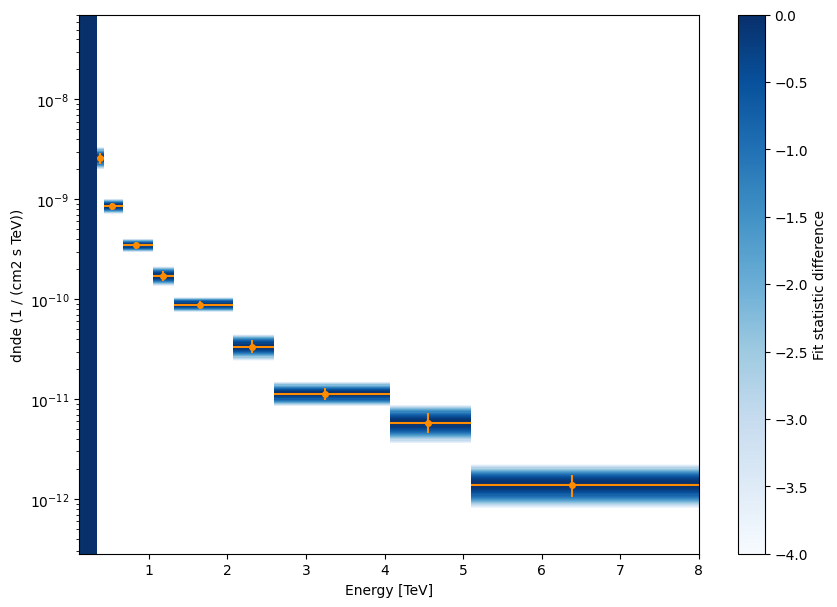

In [112]:
fig, ax = plt.subplots(figsize=(10,7))
flux_points.plot(ax=ax, sed_type="dnde", color="darkorange")
flux_points.plot_ts_profiles(ax=ax, sed_type="dnde")
ax.set_xscale('linear')

This is the plot that you actually want as output:

(<Axes: xlabel='Energy [TeV]', ylabel='e2dnde [erg / (cm2 s)]'>,
 <Axes: xlabel='Energy [TeV]', ylabel='Residuals\n (data - model) / model'>)

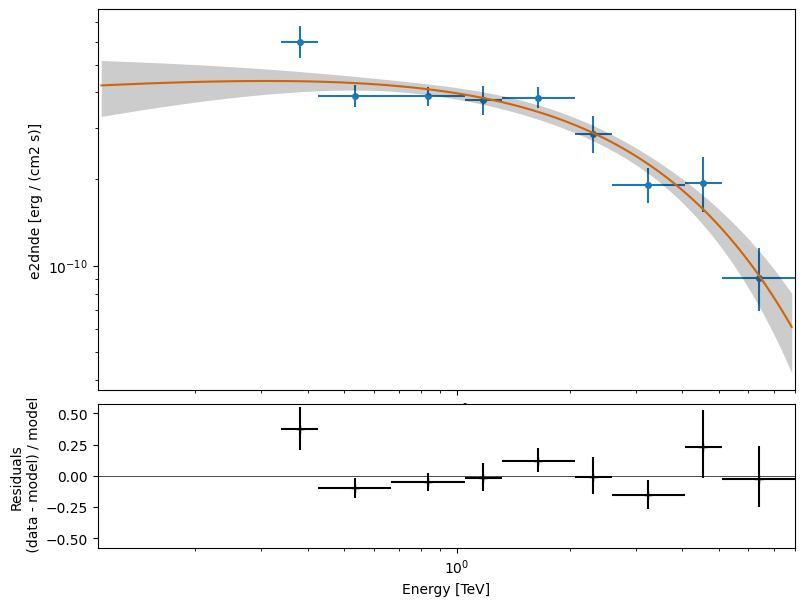

In [113]:
flux_points_dataset = FluxPointsDataset(data=flux_points, models=model_best_joint)
flux_points_dataset.plot_fit()

# Pretty plot

This does the same thing but lets you change some of the plotting parameters a bit more easily for nicer plots (e.g., SED type, colour, axis labels, scale, etc.)

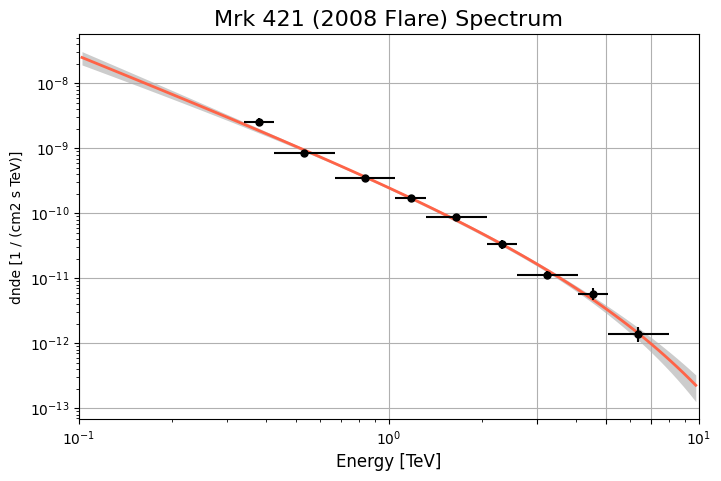

In [114]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,5))

plt.title("Mrk 421 (2008 Flare) Spectrum",fontsize=16)

energy_bounds = [0.1, 10] * u.TeV
spectral_model.plot(energy_bounds,label='Exponential Cutoff Power-Law Fit',color='tomato',linewidth=2)
spectral_model.plot_error(energy_bounds,alpha=0.2,color='lightcyan')
flux_points.plot(sed_type="dnde",color='k',markersize=5)

plt.xlabel('Energy [TeV]',fontsize=12)
plt.xticks([0.1,1,3,5,7,10])
plt.grid()

This just prints out the above data points, which you can also save to a file if you need them later

In [115]:
gammapy_flux = flux_points.to_table(sed_type='dnde')
display(gammapy_flux)

e_ref,e_min,e_max,dnde,dnde_err,dnde_errp,dnde_errn,dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[2],float32[2],float64,bool,float64[2],bool,float64[11],float64[11]
0.13784047266687824,0.11000000000000001,0.17272723550025817,nan,nan,nan,nan,nan,nan,nan,nan .. nan,0.0 .. 0.0,0.0,False,0.0 .. 0.0,False,0.2 .. 4.999999999999999,nan .. nan
0.19335386443568947,0.17272723550025817,0.216443670761807,nan,nan,nan,nan,nan,nan,nan,nan .. nan,0.0 .. 0.0,0.0,False,0.0 .. 0.0,False,0.2 .. 4.999999999999999,nan .. nan
0.27122452621419674,0.216443670761807,0.3398701535655908,nan,nan,nan,nan,nan,nan,nan,nan .. nan,0.0 .. 0.0,0.0,False,0.0 .. 0.0,False,0.2 .. 4.999999999999999,nan .. nan
0.3804565470403768,0.3398701535655908,0.4258896601167774,2.585928688923728e-09,3.2508477144462175e-10,3.3812397940426443e-10,3.1233729569019234e-10,3.28884690571399e-09,236.44176360574397,15.37666295415699,69.9969071752154 .. 0.0,66.64396 .. 0.0,1.370399331790395e-07,False,70.0 .. 0.0,True,0.2 .. 4.999999999999999,116.9715642133915 .. 176.49996590251556
0.5336802914039337,0.4258896601167774,0.6687522147283229,8.503089447644758e-10,7.423199624979266e-11,7.631643030052793e-11,7.2177347502114e-11,1.007169182802064e-09,523.4976273497939,22.880070527640292,103.22493400803205 .. 38.759908014284036,100.28376 .. 36.358917,1.8731659623128394,False,103.0 .. 39.0,True,0.2 .. 4.999999999999999,178.44924798292516 .. 768.421299411504
0.8380101943197606,0.6687522147283229,1.0501065571336206,3.4516645222209334e-10,2.6463783402518353e-11,2.712790030556349e-11,2.5808136535283792e-11,4.007674535296107e-10,757.9550554384011,27.530983553778118,92.99973796182441 .. 84.98950456405849,92.0016 .. 82.12004,2.044492826794368,False,90.0 .. 88.0,True,0.2 .. 4.999999999999999,250.27850266214352 .. 906.7370766496332
1.1755075006149749,1.0501065571336206,1.3158834925989673,1.6991290741552357e-10,1.9432865312227433e-11,2.0177738450216298e-11,1.8711971533523737e-11,2.1181909653117072e-10,376.15587372587413,19.394738300009983,39.291977174338726 .. 38.70667577337895,39.115055 .. 38.108433,0.1496745985538439,False,41.0 .. 37.0,True,0.2 .. 4.999999999999999,119.07751617456088 .. 378.2793165564879
1.6489272963125834,1.3158834925989673,2.066262890154946,8.802153305580805e-11,7.496875667704119e-12,7.709421019459185e-12,7.287451523092864e-12,1.0387189644900352e-10,674.3084742712554,25.967450284370535,69.07554874728798 .. 70.84584857495491,68.72774 .. 70.23488,17.928300593593292,False,50.0 .. 90.0,True,0.2 .. 4.999999999999999,260.60020325296824 .. 562.7632749339375


And this is the $\chi^2$ of your fit to the spectral model

In [116]:
def reduced_chi_squared(y, y_model,sigma, n_params):
    chi_squared = np.sum(((y - y_model) / sigma) ** 2)
    d_o_f = len(y) - n_params
    return chi_squared, d_o_f

chisq,dof = reduced_chi_squared(gammapy_flux['dnde'],spectral_model(gammapy_flux['e_ref']),gammapy_flux['dnde_err'],4)
print(chisq,dof)

nan 8


# Overlay above analysis with fit from paper (VTSCat)

Now we're going to actually validate the fit we got with the paper we originally looked at. 

You need to download a .ecsv file from VTSCat for the SED (e.g., https://github.com/VERITAS-Observatory/VERITAS-VTSCat/blob/main/2011/2011ApJ...738...25A/VER-000049-sed-6.ecsv). If you're copy and pasting this into a new text file, make sure it saves or it will give an error about not being able to find # %ECSV version.

You should change `sed_type` in the last cell to match whichever energy flux is in the paper's .ecsv file (in this example: dnde)

In [117]:
from astropy.table import Table
paper = Table.read('mrk_421_paper_spectrum.ecsv', format='ascii.ecsv') #replace this with your paper's .ecsv file
paper

e_ref,dnde,dnde_errn,dnde_errp
TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
float32,float32,float32,float32
0.64,6.66e-10,7.09e-11,7.09e-11
0.79,4.29e-10,4.45e-11,4.45e-11
0.98,2.45e-10,2.023e-11,2.023e-11
1.21,1.708e-10,1.397e-11,1.397e-11
1.5,9.94e-11,9.117e-12,9.117e-12
1.85,4.907e-11,5.54e-12,5.54e-12
2.29,3.522e-11,4.038e-12,4.038e-12
2.828,1.82e-11,2.527e-12,2.527e-12


/tmp/ipykernel_1151726/1467437282.py:9: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0,10)


Text(0.5, 1.0, 'Mrk 421 (2008 Flare) Spectrum')

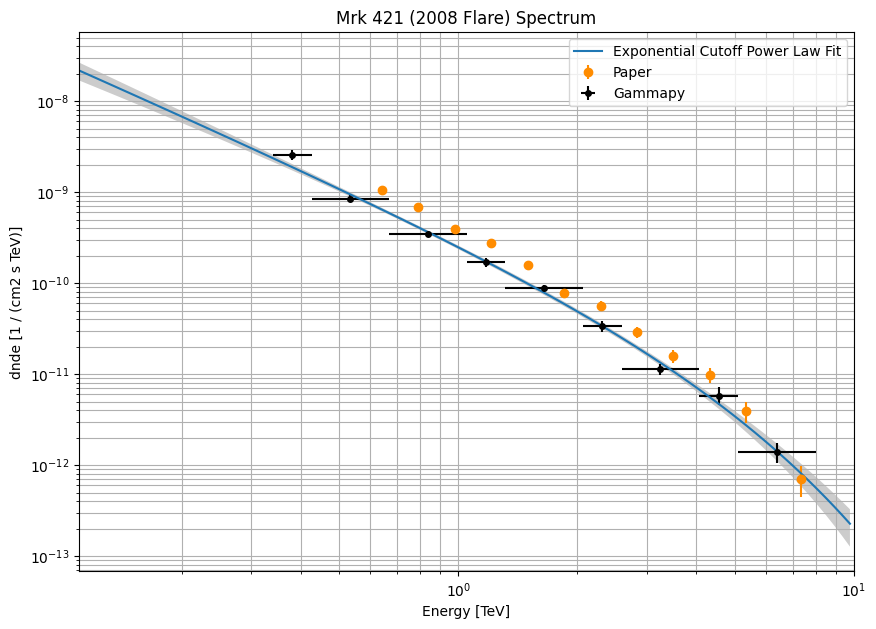

In [118]:
fig, ax = plt.subplots(figsize=(10,7))
plt.errorbar(paper['e_ref'],paper['dnde']*1.602,yerr=paper['dnde_errn']*1.602,color='darkorange',ls='',marker='o',label='Paper')
flux_points.plot(ax=ax, sed_type="dnde", color="k",label='Gammapy')
energy_bounds = [0.1, 10] * u.TeV
spectral_model.plot(energy_bounds,sed_type='dnde',label='Exponential Cutoff Power Law Fit')
spectral_model.plot_error(energy_bounds,sed_type='dnde',alpha=0.2)
ax.grid(which='minor')
ax.grid(which='major')
ax.set_xlim(0,10)
ax.set_xscale('log')
ax.legend()
plt.title('Mrk 421 (2008 Flare) Spectrum')

All done! Make sure the orange points are fairly consistent with your black points and blue fit line. Change the number/location of bins and rerun if needed. You can see above that I could probably go with finer bins and start at a higher energy.